
# **1D and 2D Circuits with/without Mirror Symmetry**



# **Set Up**

In [12]:
# ✅ Install packages (quiet mode)
!pip install -q cirq pandas

# 📦 Imports
import cirq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🎯 Global Simulator
simulator = cirq.Simulator()

# 🧊 Noise levels to test
noise_levels = [0.0, 0.5, 1.0]


# **1D layout with mirror symmetry**

---



In [13]:
def simulate_1d_symmetric(qubits, noise_levels):
    def build_circuit():
        circuit = cirq.Circuit()
        circuit.append(cirq.H(qubits[0]))
        for i in range(len(qubits) - 1):
            circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
        # Mirror SWAPs
        mid = len(qubits) // 2
        for i in range(mid):
            circuit.append(cirq.SWAP(qubits[i], qubits[-(i + 1)]))
        circuit.append(cirq.measure(*qubits, key='result'))
        return circuit

    results = {}
    for p in noise_levels:
        circuit = build_circuit()
        noise_model = cirq.ConstantQubitNoiseModel(cirq.DepolarizingChannel(p=p))
        noisy_circuit = cirq.Circuit(noise_model.noisy_moment(m, system_qubits=qubits) for m in circuit)
        result = simulator.run(noisy_circuit, repetitions=1000)
        bitstrings = [''.join(str(b) for b in r) for r in result.measurements['result']]
        results[p] = pd.Series(bitstrings).value_counts()
    return results

qubits_1d = cirq.LineQubit.range(5)
results_1d_sym = simulate_1d_symmetric(qubits_1d, noise_levels)



# **1D layout without mirror symmetry**




In [14]:
def simulate_1d_asymmetric(qubits, noise_levels):
    def build_circuit():
        circuit = cirq.Circuit()
        circuit.append(cirq.H(qubits[0]))
        for i in range(len(qubits) - 1):
            circuit.append(cirq.CNOT(qubits[i], qubits[i + 1]))
        # Randomized asymmetric SWAPs
        circuit.append([cirq.SWAP(qubits[0], qubits[1]), cirq.SWAP(qubits[3], qubits[4])])
        circuit.append(cirq.measure(*qubits, key='result'))
        return circuit

    results = {}
    for p in noise_levels:
        circuit = build_circuit()
        noise_model = cirq.ConstantQubitNoiseModel(cirq.DepolarizingChannel(p=p))
        noisy_circuit = cirq.Circuit(noise_model.noisy_moment(m, system_qubits=qubits) for m in circuit)
        result = simulator.run(noisy_circuit, repetitions=1000)
        bitstrings = [''.join(str(b) for b in r) for r in result.measurements['result']]
        results[p] = pd.Series(bitstrings).value_counts()
    return results

results_1d_asym = simulate_1d_asymmetric(qubits_1d, noise_levels)


# **2D layout with mirror symmetry**


In [15]:
def simulate_2d_symmetric(qubits, noise_levels):
    def build_circuit():
        circuit = cirq.Circuit()
        pairs = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
        for q in pairs:
            circuit.append(cirq.H(cirq.GridQubit(*q)))
        for i in range(len(pairs) - 1):
            q1 = cirq.GridQubit(*pairs[i])
            q2 = cirq.GridQubit(*pairs[i + 1])
            circuit.append(cirq.CNOT(q1, q2))
        # Mirror SWAPs: (0,0)<->(0,4), (0,1)<->(0,3)
        circuit.append([
            cirq.SWAP(cirq.GridQubit(0,0), cirq.GridQubit(0,4)),
            cirq.SWAP(cirq.GridQubit(0,1), cirq.GridQubit(0,3))
        ])
        circuit.append(cirq.measure(*(cirq.GridQubit(0,i) for i in range(5)), key='result'))
        return circuit

    results = {}
    for p in noise_levels:
        circuit = build_circuit()
        noise_model = cirq.ConstantQubitNoiseModel(cirq.DepolarizingChannel(p=p))
        noisy_circuit = cirq.Circuit(noise_model.noisy_moment(m, system_qubits=qubits) for m in circuit)
        result = simulator.run(noisy_circuit, repetitions=1000)
        bitstrings = [''.join(str(b) for b in r) for r in result.measurements['result']]
        results[p] = pd.Series(bitstrings).value_counts()
    return results

qubits_2d = [cirq.GridQubit(0, i) for i in range(5)]
results_2d_sym = simulate_2d_symmetric(qubits_2d, noise_levels)


# **2D layout without mirror symmetry**


In [16]:
def simulate_2d_asymmetric(qubits, noise_levels):
    def build_circuit():
        circuit = cirq.Circuit()
        pairs = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
        for q in pairs:
            circuit.append(cirq.H(cirq.GridQubit(*q)))
        for i in range(len(pairs) - 1):
            q1 = cirq.GridQubit(*pairs[i])
            q2 = cirq.GridQubit(*pairs[i + 1])
            circuit.append(cirq.CNOT(q1, q2))
        # Asymmetric SWAPs: (0,0)<->(0,1), (0,3)<->(0,4)
        circuit.append([
            cirq.SWAP(cirq.GridQubit(0,0), cirq.GridQubit(0,1)),
            cirq.SWAP(cirq.GridQubit(0,3), cirq.GridQubit(0,4))
        ])
        circuit.append(cirq.measure(*(cirq.GridQubit(0,i) for i in range(5)), key='result'))
        return circuit

    results = {}
    for p in noise_levels:
        circuit = build_circuit()
        noise_model = cirq.ConstantQubitNoiseModel(cirq.DepolarizingChannel(p=p))
        noisy_circuit = cirq.Circuit(noise_model.noisy_moment(m, system_qubits=qubits) for m in circuit)
        result = simulator.run(noisy_circuit, repetitions=1000)
        bitstrings = [''.join(str(b) for b in r) for r in result.measurements['result']]
        results[p] = pd.Series(bitstrings).value_counts()
    return results

results_2d_asym = simulate_2d_asymmetric(qubits_2d, noise_levels)


# **Visualization**

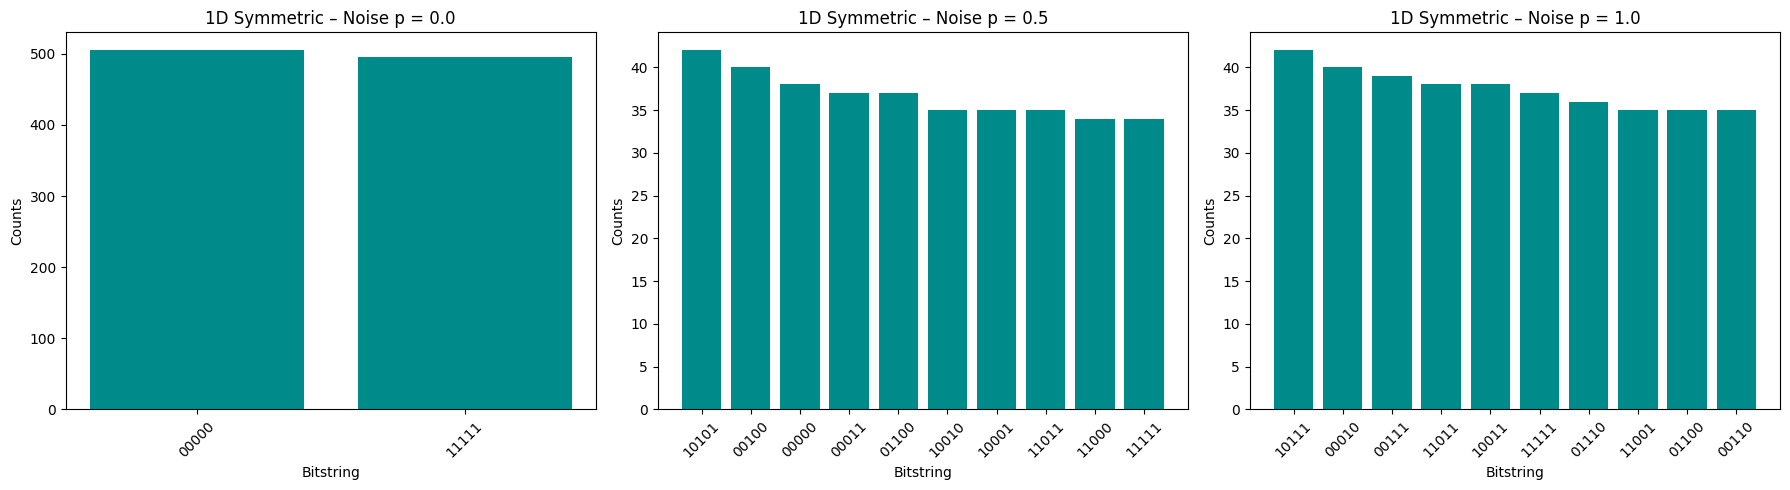

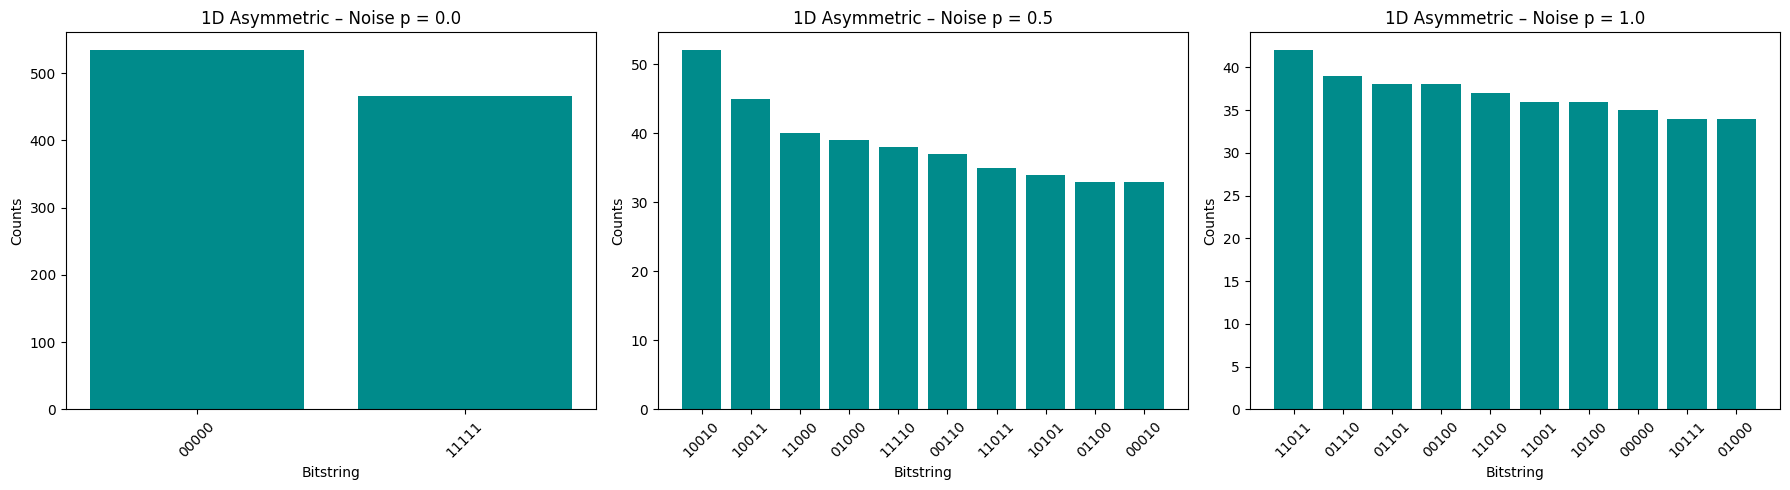

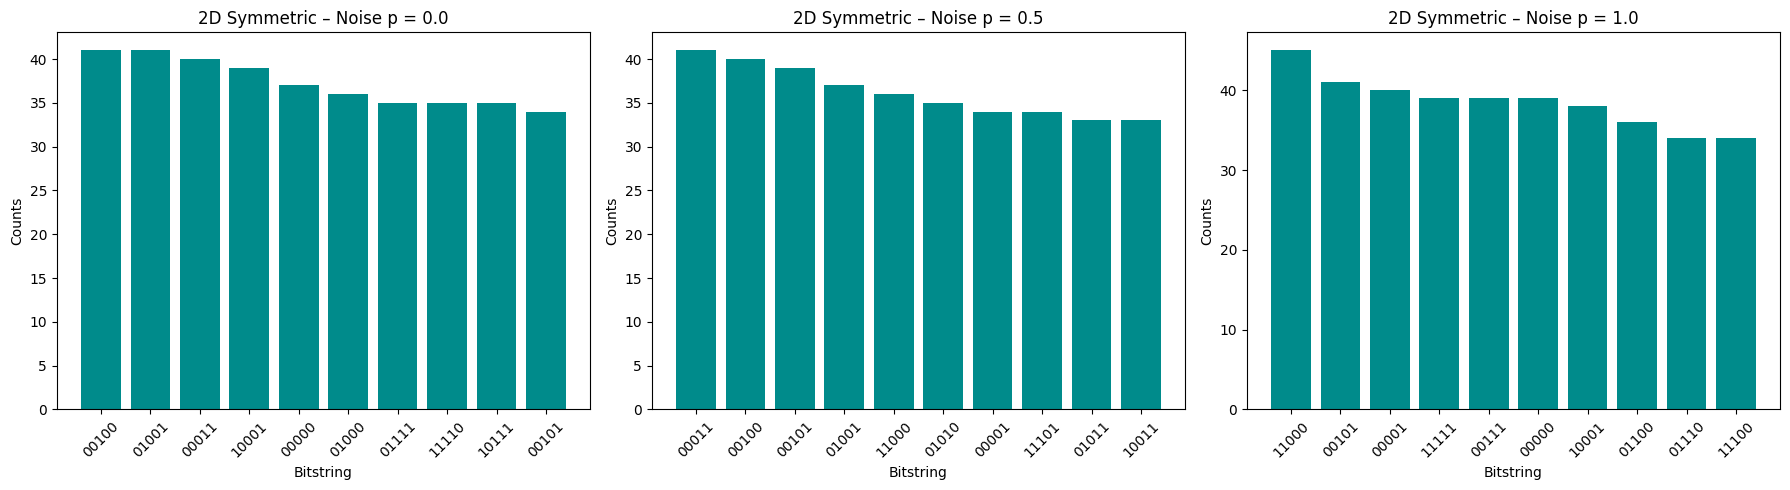

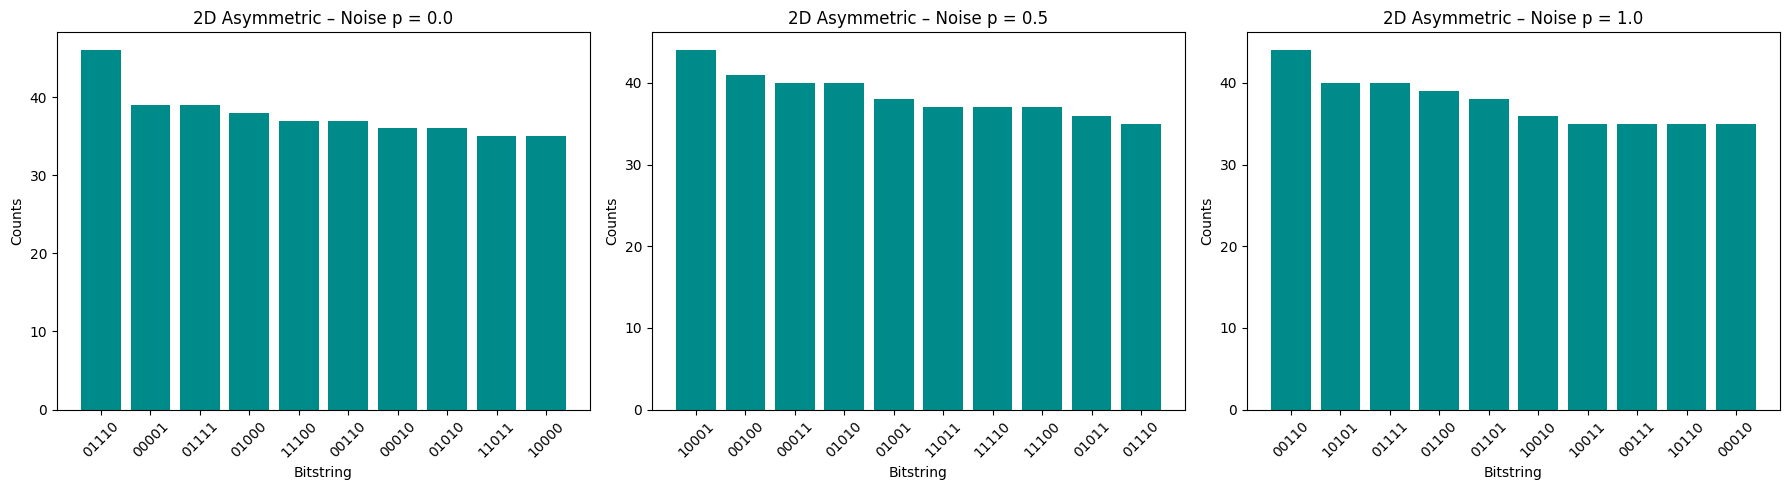

In [17]:
def visualize_top_counts(results_dict, title_prefix):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for idx, p in enumerate(noise_levels):
        df = results_dict[p].reset_index()
        df.columns = ['bitstring', 'counts']
        df_sorted = df.sort_values(by='counts', ascending=False)[:10]

        axs[idx].bar(df_sorted['bitstring'], df_sorted['counts'], color='darkcyan')
        axs[idx].set_title(f"{title_prefix} – Noise p = {p}")
        axs[idx].set_xlabel("Bitstring")
        axs[idx].set_ylabel("Counts")
        axs[idx].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# 🔍 Call visualizer on each set
visualize_top_counts(results_1d_sym, "1D Symmetric")
visualize_top_counts(results_1d_asym, "1D Asymmetric")
visualize_top_counts(results_2d_sym, "2D Symmetric")
visualize_top_counts(results_2d_asym, "2D Asymmetric")
